# DisaXta Vision Model: WaverX-Vision

## Requirements


In [ ]:
!pip install -r requirements.txt

## Data Preparation

### Model configuration

In [ ]:
# import the necessary packages
import os
# initialize the path to the *original* input directory of images
INPUT_DATASET = "dataset"
# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
BASE_PATH = "model_dataset"
# derive the training, validation, and testing directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])

# define the amount of data that will be used training
TRAIN_SPLIT = 0.75
# the amount of validation data will be a percentage of the
# *training* data
VAL_SPLIT = 0.1
# define the names of the classes
CLASSES = ["Earthquake", "Drought",
           "Damaged Infrastructure", "Human Damage", "Human", "Land Slide", "Non Damage Buildings and  Street", "Non Damage Wildlife Forest",
           "Sea", "Urban Fire", "Wild Fire", "Water Disaster"]

CLASSES.sort()

# initialize the initial learning rate, batch size, and number of
# epochs to train for
INIT_LR = 1e-4
BS = 32
NUM_EPOCHS = 50
UNFROZEN_NUM_EPOCHS = 20
# define the path to the serialized output model after training
MODEL_PATH = "model"
# define the path to the output training history plots
UNFROZEN_PLOT_PATH = os.path.sep.join(["output", "plots/unfrozen.png"])
WARMUP_PLOT_PATH = os.path.sep.join(["output", "plots/warmup.png"])

### Dataset Building

In [ ]:
import random
import shutil
import os
import config
from imutils import paths
from PIL import Image
from datetime import datetime


#grab the paths to all input images in the original input directory
# and shuffle them
imagePaths = list(paths.list_images(config.INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)
# compute the training and testing split
index = int(len(imagePaths) * config.TRAIN_SPLIT)
trainPaths = imagePaths[:index]
testPaths = imagePaths[index:]
# we'll be using part of the training data for validation
index = int(len(trainPaths) * config.VAL_SPLIT)
valPaths = trainPaths[:index]
trainPaths = trainPaths[index:]
# define the datasets that we'll be building
datasets = [
    ("training", trainPaths, config.TRAIN_PATH),
    ("validation", valPaths, config.VAL_PATH),
    ("testing", testPaths, config.TEST_PATH)
]

# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
    # show which data split we are creating
    print("[INFO] building '{}' split".format(dType))
    # if the output base output directory does not exist, create it
    if not os.path.exists(baseOutput):
        print("[INFO] 'creating {}' directory".format(baseOutput))
        os.makedirs(baseOutput)
    # loop over the input image paths
    for inputPath in imagePaths:
        # extract the filename of the input image along with its
        # corresponding class label
        filename = inputPath.split(os.path.sep)[-1]
        label = inputPath.split(os.path.sep)[-2]
        # build the path to the label directory
        labelPath = os.path.sep.join([baseOutput, label])
        # if the label output directory does not exist, create it
        if not os.path.exists(labelPath):
            print("[INFO] 'creating {}' directory".format(labelPath))
            os.makedirs(labelPath)
        # construct the path to the destination image and then copy
        # the image itself
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, p)

# Total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(config.TRAIN_PATH)))
totalVal = len(list(paths.list_images(config.VAL_PATH)))
totalTest = len(list(paths.list_images(config.TEST_PATH)))


def filter_valid_images(directory):
    valid_files = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        for file in os.listdir(file_path):
            try:
                # Attempt to open the file as an image
                Image.open(f'{file_path}/{file}')
                current_time = datetime.now()
                formatted_time = current_time.strftime('%Y-%m-%d %H:%M:%S')
                valid_files.append(file)
                # Log results
                with open('dataset_filtering.log', 'a') as log:
                    log.write(f'{file} is valid -[{formatted_time}]\n')
            except OSError as e:
                # Handle exceptions and log the error
                image_path = os.path.join(file_path, file)
                current_time = datetime.now()
                formatted_time = current_time.strftime('%Y-%m-%d %H:%M:%S')
                os.remove(image_path)
                with open('dataset_filtering.log', 'w') as log:
                    log.write(f"Skipping file {file}: {e} -[{formatted_time}]\n")

            except Exception as e:
                # Handle other exceptions
                image_path = os.path.join(file_path, file)
                current_time = datetime.now()
                formatted_time = current_time.strftime('%Y-%m-%d %H:%M:%S')
                os.remove(image_path)
                with open('dataset_filtering.log', 'w') as log:
                    log.write(f"Unexpected error: {e} -[{formatted_time}]\n")
    return len(valid_files)

valid_train = filter_valid_images(config.TRAIN_PATH)
print("[INFO] Total training data === {}".format(totalTrain))
print("[INFO] Total valid training data === {}".format(valid_train))
valid_val = filter_valid_images(config.VAL_PATH)
print("[INFO] Total validating data === {}".format(totalVal))
print("[INFO] Total valid validating data === {}".format(valid_val))
valid_test = filter_valid_images(config.TEST_PATH)
print("[INFO] Total testing data === {}".format(totalTest))
print("[INFO] Total valid testing data === {}".format(valid_test))


## Build Model

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import config
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib
matplotlib.use("Agg")

LAYERS_TO_FREEZE = 172
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--plot", type=str, default="plot.png",
                help="path to output loss/accuracy plot")
args = vars(ap.parse_args(args=[]))
# Total number of image paths in training, validation,
# and testing directories
total_train = len(list(paths.list_images(config.TRAIN_PATH)))
total_val = len(list(paths.list_images(config.VAL_PATH)))
total_test = len(list(paths.list_images(config.TEST_PATH)))


def freeze_layer(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False
    opt = Adam(learning_rate=config.INIT_LR, decay=config.INIT_LR / config.NUM_EPOCHS)
    print("[INFO] compiling model...")
    model.compile(loss="binary_crossentropy", optimizer=opt,
                  metrics=["accuracy"])
    return model



def new_layer(base_model):
    # construct the new layer of the model that will be placed on top of the
    # the base model
    top_model = base_model.output
    top_model = AveragePooling2D(pool_size=(7, 7))(top_model)
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(256, activation="relu")(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(len(config.CLASSES), activation="softmax")(top_model)
    model = Model(inputs=base_model.input, outputs=top_model)
    return model

def unfreeze_layer(baseModel, model):
    for layer in baseModel.layers[15:]:
        layer.trainable = True
    # loop over the layers in the model and show which ones are trainable
    # or not
    for layer in baseModel.layers:
        print("{}: {}".format(layer, layer.trainable))
    # for the changes to the model to take affect we need to recompile
    # the model, this time using SGD with a *very* small learning rate
    print("[INFO] re-compiling model...")
    opt = ADAM(learning_rate=config.INIT_LR, decay=config.INIT_LR / config.UNFROZEN_NUM_EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
                  metrics=["accuracy"])
    return model

def train_model(model, epochs):
    # train the model
    print("[INFO] training model...")
    H = model.fit(
        train_gen,
        steps_per_epoch=total_train // config.BS,
        validation_data=val_gen,
        validation_steps=total_val // config.BS,
        epochs=epochs)
    return H

def plot_training(H, N, plot_path):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plot_path)

print("Total training data === {}".format(total_train))
print("Total validating data === {}".format(total_val))
print("Total testing data === {}".format(total_test))

# initialize the training training data augmentation object
train_aug = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
val_aug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_aug.mean = mean
val_aug.mean = mean


# initialize the training generator
train_gen = train_aug.flow_from_directory(
    config.TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=config.BS)
# initialize the validation generator
val_gen = val_aug.flow_from_directory(
    config.VAL_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=config.BS)
# initialize the testing generator
test_gen = val_aug.flow_from_directory(
    config.TEST_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=config.BS)


# off
print("[INFO] preparing model...")
base_model = ResNet50(weights="imagenet", include_top=False,
                     input_tensor=Input(shape=(224, 224, 3)))

# place the top FC model on top of the base model (this will become
# the actual model we will train)
model = new_layer(base_model)
model = freeze_layer(model, base_model)


H = train_model(model, config.NUM_EPOCHS)
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
test_gen.reset()
predIdxs = model.predict(test_gen, steps=(total_test // config.BS) + 1)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(test_gen.classes, predIdxs,
                            target_names=test_gen.class_indices.keys()))
N = config.NUM_EPOCHS
plot_training(H, N, config.WARMUP_PLOT_PATH)

# reset our data generators
train_gen.reset()
val_gen.reset()
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
model = unfreeze_layer(base_model, model)
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = train(model, config.UNFROZEN_NUM_EPOCHS)

print("[INFO] evaluating after fine-tuning network...")
testGen.reset()
predIdxs = model.predict(x=testGen,
                         steps=(totalTest // config.BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
                            target_names=testGen.class_indices.keys()))
N = config.UNFROZEN_NUM_EPOCHS
plot_training(H, 20, config.UNFROZEN_PLOT_PATH)

# serialize the model to disk
print("[INFO] saving model...")
model.save(f'{config.MODEL_PATH}/keras')



## Model Conversion to IR

In [ ]:
from openvino import convert_model
import openvino
import tensorflow as tf

loaded_model =  tf.keras.models.load_model('model/disaster_detector.h5')

# The paths of the source and converted models

ov_model = convert_model(loaded_model)
# save model to OpenVINO IR for later use
openvino.save_model(ov_model, 'model/ov model/model.xml')


## Model Quantization

In [ ]:
import numpy as np
import openvino
from sklearn.metrics import accuracy_score
import nncf
import tensorflow as tf
import os
import tensorflow_datasets as tfds
from openvino.runtime import Core
from imutils import paths
import config

# Initialize the Inference Engine Core
ie = Core()

# Path to the XML file of the IR model (architecture)
xml_file = 'model/ov model/model.xml'

# Path to the bin file of the IR model (weights)
bin_file = 'model/ov model/model.bin'

# Load the IR model
model = ie.read_model(model=xml_file, weights=bin_file)

# Define a function to resize and normalize the images
def preprocess_image(images):
    # Resize the image to the desired shape (e.g., (224, 224))
     # Ensure the image is a TensorFlow float32 tensor
    image = images["image"]
    label = images["label"]
    image = tf.image.resize(image, (224, 224))  # Change the dimensions accordingly
    # Normalize pixel values to the range [0, 1]
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)  # Adds a new input channel at the last axis
    label = tf.expand_dims(label, axis=0)  # Adds a new input channel at the last axis
    dataset = {"image": image, "label": label}
    return dataset

val_loader = tfds.load("caltech101", split="test")
val_loader = val_loader.map(preprocess_image)
# Provide validation part of the dataset to collect statistics needed for the compression algorithm
# Step 1: Initialize transformation function
def transform_fn(data_item):
    images = data_item["image"]
    print(images)
    return images

calibration_dataset = nncf.Dataset(val_loader, transform_fn)
validation_dataset = nncf.Dataset(val_loader, transform_fn)

def validate(model: openvino.runtime.CompiledModel,
             validation_loader) -> float:
    predictions = []
    references = []

    output = model.outputs[0]

    for images in validation_loader:
        pred = model(images["image"])[output]
        predictions.append(np.argmax(pred, axis=1))
        references.append(images["label"])
        print(pred)

    predictions = np.concatenate(predictions, axis=0)
    references = np.concatenate(references, axis=0)
    print("[INFO] Validation complete")
    return accuracy_score(predictions, references)



print("[INFO] Quantizing model")
quantized_model = nncf.quantize_with_accuracy_control(model,
                        calibration_dataset=calibration_dataset,
                        validation_dataset=validation_dataset,
                        validation_fn=validate,
                        max_drop=0.01)
print(quantized_model)
print("[INFO] Saving quantized model")
openvino.serialize(quantized_model, "model/quantized model/quantized_model.xml")



## Inference Test

### Model Inference

Model located at model/ov model
Quantized model located at model/quantized model
The openvino model depicts Non Damage Wildlife Forest


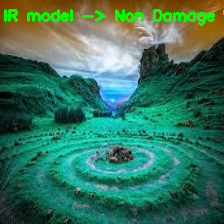

The openvino quantized model depicts Non Damage Wildlife Forest


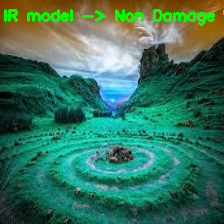

Calculating WaverX-Vision in IR format benchmarks
IR model in Inference Engine/CPU: 0.1457 seconds per image, FPS: 6.86
Calculating WaverX-Vision in Quantized IR format Benchmarks
IR quantized model in Inference Engine/CPU: 0.1395 seconds per image, FPS: 7.17


In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
from pathlib import Path
from openvino import Core
import config
from google.colab.patches import cv2_imshow


image = cv2.imread(filename="inference_test/images/environ.jpeg")
# our model was trained on RGB ordered images but OpenCV represents
# images in BGR order, so swap the channels,
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



model_path = Path("model/ov model/")
model = Path(f"{model_path}/model.xml")
weights = Path(f"{model_path}/model.bin")

quantized_model_path = Path("model/quantized model/")
quantized_model = Path(f"{model_path}/model.xml")
quantized_weights = Path(f"{model_path}/model.bin")
print("Model located at {}".format(model_path))
print("Quantized model located at {}".format(quantized_model_path))

core = Core()
read_model = core.read_model(model=model, weights=weights)
compiled_model = core.compile_model(model=model, device_name="CPU")
read_quantized_model = core.read_model(model=quantized_model, weights=quantized_weights)
compiled_quantized_model = core.compile_model(model=quantized_model, device_name="CPU")

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

quantized_input_layer = compiled_quantized_model.input(0)
quantized_output_layer = compiled_quantized_model.output(0)

# Resize image to network input image shape
resized_image = cv2.resize(src=image, dsize=(224, 224))

# Transpose image to network input shape
input_image = np.expand_dims(np.transpose(resized_image, (1, 0, 2)), 0)

result = compiled_model(inputs={input_layer: input_image})[output_layer][0]
quantized_result = compiled_quantized_model(inputs={quantized_input_layer: input_image})[quantized_output_layer][0]
result_index = np.argmax(result)
quantized_result_index = np.argmax(quantized_result)

labels = config.CLASSES

print(f"The openvino model depicts {labels[result_index]}")
# draw the prediction on the output image
text = "IR model -> {}: {:.2f}%".format(labels[result_index], result[result_index] * 100)
cv2.putText(resized_image, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
            (0, 255, 0), 2)
# show the processed image
cv2_imshow(resized_image)
cv2.waitKey(0)

print(f"The openvino quantized model depicts {labels[quantized_result_index]}")

text = "IR model -> {}: {:.2f}%".format(labels[quantized_result_index], quantized_result[quantized_result_index] * 100)
cv2.putText(resized_image, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
            (0, 255, 0), 2)
# show the processed image
cv2_imshow(resized_image)
cv2.waitKey(0)




print("Calculating WaverX-Vision benchmarks in IR format ")
num_images = 1000
start = time.perf_counter()
for _ in range(num_images):
    compiled_model(inputs={input_layer: input_image})
end = time.perf_counter()
time_ir = end - start
print(
    f"IR model in Inference Engine/CPU: {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)

print("Calculating WaverX-Vision in benchmarks Quantized IR format")
num_images = 1000
start = time.perf_counter()
for _ in range(num_images):
    compiled_quantized_model(inputs={quantized_input_layer: input_image})
end = time.perf_counter()
time_ir = end - start
print(
    f"IR quantized model in Inference Engine/CPU: {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)